### Notebook to calculate the stability change of each sample base on Iteratively Reweighted Least Squares in CCLE samples
- For each protein-ttype perform an IRLS. Samples with any mutation, high-level amplificaion of mutations in upstream E3 ligases are discarded
- It performs one regression per bimodaly component
- For each cell line calculate the Residual  as the distance of y to the line of regression. 
- Normalize the residual by the STD of RPPA values and by RNA dispersion Residual Normalized = Residual*RNA_var / RPPA_var

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.regression.linear_model import WLS
import pickle

###  Input paths

In [2]:
base = "../../"
dataset_rppa = os.path.join(base,"data/rppa_matched_ccle.tsv.gz")
#output_plots_path = os.path.join(base,"Figure2/plots/regression_plots/")
output_irls_info = os.path.join(base,"data/regression_irls_info_ccle.tsv")
dataset_rppa_irls = os.path.join(base,"data/rppa_matched_irls_ccle.tsv.gz")
path_dict_bimodality = os.path.join(base,"data/info_bimodality.pickle") # DIctionary with the type of regulation of each sample
path_groups_bm = os.path.join(base,"data/bimodality_groups.tsv") # Dataframe that contains information the group of each sample in case of BM


### Load information about the group of each sample (bimodality )

In [3]:
df_groups = pd.read_csv(path_groups_bm,sep="\t")
dict_bimodality = pickle.load(open(path_dict_bimodality,'rb'))

### Load RPPA

In [4]:
df_rppa_raw = pd.read_csv(dataset_rppa,sep="\t",compression="gzip")
df_rppa = pd.merge(df_rppa_raw,df_groups,how="left") # Include group into 
df_rppa["Group"].fillna(0,inplace=True) # Those cases with no information set component 0
df_rppa["Group"] =  df_rppa.Group.astype(int)
df_rppa["Type_Regulation"] = df_rppa.apply(lambda row:dict_bimodality[row["Protein"]],axis=1)

### Functions to calculate the IRLS regression

In [5]:
def provide_exog(covariate):
    exog_data = np.array(np.concatenate((np.array(covariate), np.ones_like(covariate))).reshape(2, len(covariate)))
    return np.transpose(exog_data)

def w_mean(x, w):
    '''weighted mean'''
    return np.dot(x, w) / np.sum(w)

def w_cov(x, y, w):
    '''weighted covariance'''
    return np.sum(w * (x - w_mean(x, w)) * (y - w_mean(y, w))) / np.sum(w)

def w_corr(x, y, w):
    '''weighted correlation'''
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))
def run_irls(x_coords,y_coords):
    exog_data = provide_exog(x_coords)
    model_irls = RLM(y_coords, exog_data)
    try:
        res_irls = model_irls.fit()
    except ZeroDivisionError:
        return np.nan,np.nan,np.nan,np.nan,np.nan
    weighted_r = w_corr(x_coords, y_coords, res_irls.weights)
    wmean = w_mean(y_coords,res_irls.weights)
    pvalue = res_irls.pvalues[0]
    slope = res_irls.params[0]
    intercept = res_irls.params[1]
    return pvalue,weighted_r,slope,intercept,wmean



### Perform the calculation 

In [6]:
def calculate_stats_regression(protein,group):
    rnav = df_rppa[(df_rppa["Group"]==group)&(df_rppa["Protein"]==protein)&(df_rppa["Phenotype"]=="WT")&(~df_rppa["Altered_E3_Ligases"])&(df_rppa["CNA"]<2)]["log2(RPKM)"].values
    rppav = df_rppa[(df_rppa["Group"]==group)&(df_rppa["Protein"]==protein)&(df_rppa["Phenotype"]=="WT")&(~df_rppa["Altered_E3_Ligases"])&(df_rppa["CNA"]<2)]["RPPA_VALUES"].values
    maskx = np.isfinite(rnav)
    masky = np.isfinite(rppav)
    rnav = rnav[maskx&masky]
    rppav = rppav[maskx&masky]
    if len(rnav) < 1 or len(rppav) < 1: # If there are no enough points

        return np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    pvalue,r_value,slope,intercept,wmean = run_irls(rnav,rppav)
    stdy = np.std(rppav)
    vary = np.var(rppav)
    stdx = np.std(rnav)
    varx = np.var(rnav)
    return  pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx

        


### Calculate the regressions for each Antibody, when its BM two regressions, when its UM only one

In [7]:
proteins = df_rppa["Protein"].unique()
list_results = []
for protein in proteins:
    # Calculate the IRLS
    if dict_bimodality[protein] == "UM":
        # Normal regression
        pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx=calculate_stats_regression(protein,0)
        list_results.append([protein,0,pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx,"UM"])
    else:
        pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx=calculate_stats_regression(protein,0)
        list_results.append([protein,0,pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx,"BM"])
        pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx=calculate_stats_regression(protein,1)
        list_results.append([protein,1,pvalue,r_value,slope,intercept,wmean,stdy,vary,stdx,varx,"BM"])
df_quality_irls = pd.DataFrame(list_results,columns=["Protein","Group","Pvalue","R_value","Slope","Intercept","Weighted_Mean","STD_RPPA","VAR_RPPA","STD_RNA","VAR_RNA","Type_Regulation"])
df_quality_irls.to_csv(output_irls_info,sep="\t",index=False)          

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


# 2. Calculate the distance to the line of regression

In [8]:
def get_distance_irls(row,d):
    if row["Type_Regulation"] == "UM":

        data = d[row["Protein"]+"-"+"0"]
    else:
        data = d[row["Protein"]+"-"+str(int(row["Group"]))]
    intercept = data[0]
    slope = data[1]
    y_rect = row["log2(RPKM)"]*slope + intercept
    return row["RPPA_VALUES"] - y_rect

def get_dictionary_rect(df_quality_irls):
    d = {}
 
    for index,row in df_quality_irls.iterrows():
        d[row["Protein"]+"-"+str(row["Group"])] = (row["Intercept"],row["Slope"])
    return d

        

## 2.2. Get the distance to the line of regression

In [9]:
d_params = get_dictionary_rect(df_quality_irls)

In [10]:
df_rppa["Raw_Residual"] = df_rppa.apply(lambda row: get_distance_irls(row,d_params),axis=1)

## 2.4. Get the normalized distance

In [11]:
df_rppa = pd.merge(df_rppa,df_quality_irls[["Protein","Group","STD_RNA","STD_RPPA"]],how="left")

In [12]:
df_rppa["Stability_Change"] = df_rppa["Raw_Residual"]*(df_rppa["STD_RNA"]/df_rppa["STD_RPPA"])

In [13]:
df_rppa["ABS_Stability_Change"] = np.abs(df_rppa["Stability_Change"])

In [14]:
df_rppa.drop(["STD_RNA","STD_RPPA"],axis=1,inplace=True)

### 2.5. Remove nans

In [15]:
df_rppa = df_rppa[np.isfinite(df_rppa["Stability_Change"])]

In [16]:
df_rppa.to_csv(dataset_rppa_irls,sep="\t",index=False,compression="gzip")

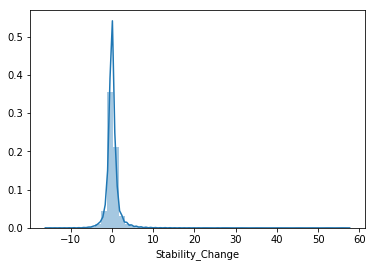

In [19]:
import seaborn as sns
%matplotlib inline
sns.distplot(df_rppa.Stability_Change)

In [18]:
dataset_rppa_irls

'/workspace/projects/ubiquitins/codereview/degradation/data/rppa_matched_irls_ccle.tsv.gz'